# Setup

In [ ]:
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Pipeline


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:

file_path = "/content/drive/MyDrive/24fall_dlProject/data/BTC-USD_stock_data_with_indicators.csv"

data = pd.read_csv(file_path,index_col='Date',parse_dates=['Date'])

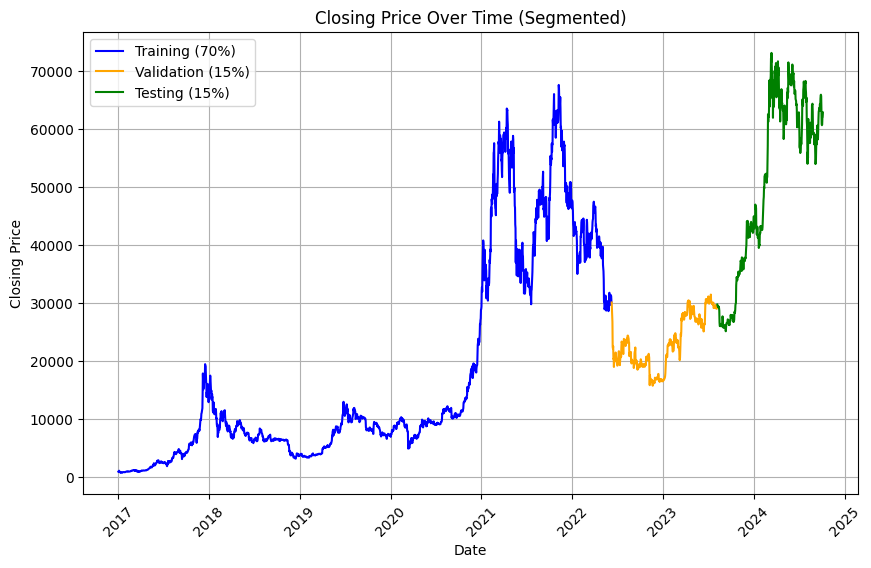

In [ ]:
close_data = data['Close'].values  # Get 'Close' data as a NumPy array
total_data_points = len(close_data)
segment1_end = int(total_data_points * 0.7)
segment2_end = int(total_data_points * (0.7 + 0.15))

plt.figure(figsize=(10, 6))

# Plotting segments with different colors
plt.plot(data.index[:segment1_end], close_data[:segment1_end], label='Training (70%)', color='blue')
plt.plot(data.index[segment1_end:segment2_end], close_data[segment1_end:segment2_end], label='Validation (15%)', color='orange')
plt.plot(data.index[segment2_end:], close_data[segment2_end:], label='Testing (15%)', color='green')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time (Segmented)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
def data_preprocessing_with_closed_price_and_min_max_scaler(data, seq_length=60):
    train_ratio = 0.7
    val_ratio = 0.15
    new_data = data.drop(columns=["Adj Close"])
    close_data = new_data.values.reshape(2836, 18)
    scaler = MinMaxScaler(feature_range=(0, 10))
    data_scaled = scaler.fit_transform(close_data)
    data_scaled = pd.DataFrame(data_scaled)

    def create_feature_datasets(data, x_size):
        x_datasets = []
        y_datasets = []
        for i in range(len(data) - x_size):
            x = data[i:i + x_size].values.reshape(-1, 18)
            y = data[i + x_size:i + x_size + 1][3].values.reshape(1)
            x_datasets.append(x)
            y_datasets.append(y)
        X = np.array(x_datasets)
        y = np.array(y_datasets)
        X_train =  X[23:int(len(X) * train_ratio)]
        y_train = y[23:int(len(y) * train_ratio)]
        X_val = X[int(len(X) * train_ratio):int(len(X) * (train_ratio + val_ratio))]
        y_val = y[int(len(y) * train_ratio):int(len(y) * (train_ratio + val_ratio))]
        X_test = X[int(len(X) * (train_ratio + val_ratio)):]
        y_test = y[int(len(y) * (train_ratio + val_ratio)):]

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        return torch.Tensor(X_train_shuffled).to(device), torch.Tensor(X_val).to(device), torch.Tensor(X_test).to(device), torch.Tensor(y_train_shuffled).to(device), torch.Tensor(y_val).to(device), torch.Tensor(y_test).to(device)

    return create_feature_datasets(data_scaled, seq_length), scaler

(X_train, X_val, X_test, y_train, y_val, y_test), min_max_scaler = data_preprocessing_with_closed_price_and_min_max_scaler(data, 60)

# Baseline Model

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size

        # Input embedding to project input_size to hidden_size
        self.input_proj = nn.Linear(input_size, hidden_size)

        # Positional encoding for sequence information
        self.positional_encoding = PositionalEncoding(hidden_size, dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=8, dim_feedforward=hidden_size*4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)

        # Project input to the hidden_size
        x = self.input_proj(x)

        # Apply positional encoding
        x = self.positional_encoding(x)

        # Transformer expects input in (seq_length, batch_size, hidden_size) format
        x = x.permute(1, 0, 2)  # Change to (seq_length, batch_size, hidden_size)

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Get the output from the last time step
        x = x[-1, :, :]  # Last time step, shape: (batch_size, hidden_size)

        # Fully connected layer
        x = self.fc(x)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, hidden_size)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Training

In [ ]:
class MeanAbsoluteRelativeErrorLoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon  # To avoid division by zero

    def forward(self, y_pred, y_true):
        # Compute the absolute relative error
        relative_error = torch.abs((y_true - y_pred) / (y_true + self.epsilon))
        return torch.mean(relative_error)

In [ ]:
# create a nn class (just-for-fun choice :-)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
# Hyperparameters
input_size = 18
hidden_size = 128
num_layers = 2
dropout = 0.1
output_size = 1
learning_rate = 0.00001
num_epochs = 300
batch_size = 128

# Create dataset and DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = TransformerModel(input_size, hidden_size, num_layers, output_size, dropout)
model.to(device)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = []

# Training loop with batching
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    epoch_losses.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [5/300], Loss: 2.5168
Epoch [10/300], Loss: 2.0774
Epoch [15/300], Loss: 1.3654
Epoch [20/300], Loss: 1.0440
Epoch [25/300], Loss: 0.7837
Epoch [30/300], Loss: 0.6808
Epoch [35/300], Loss: 0.6469
Epoch [40/300], Loss: 0.5923
Epoch [45/300], Loss: 0.6334
Epoch [50/300], Loss: 0.5799
Epoch [55/300], Loss: 0.5593
Epoch [60/300], Loss: 0.5677
Epoch [65/300], Loss: 0.4405
Epoch [70/300], Loss: 0.4058
Epoch [75/300], Loss: 0.5262
Epoch [80/300], Loss: 0.4070
Epoch [85/300], Loss: 0.3933
Epoch [90/300], Loss: 0.4059
Epoch [95/300], Loss: 0.3858
Epoch [100/300], Loss: 0.3254
Epoch [105/300], Loss: 0.4495
Epoch [110/300], Loss: 0.3847
Epoch [115/300], Loss: 0.3258
Epoch [120/300], Loss: 0.3413
Epoch [125/300], Loss: 0.3156
Epoch [130/300], Loss: 0.3349
Epoch [135/300], Loss: 0.3280
Epoch [140/300], Loss: 0.3350
Epoch [145/300], Loss: 0.3153
Epoch [150/300], Loss: 0.3618
Epoch [155/300], Loss: 0.2928
Epoch [160/300], Loss: 0.3268
Epoch [165/300], Loss: 0.2967
Epoch [170/300], Loss: 0.2697


# Visualization

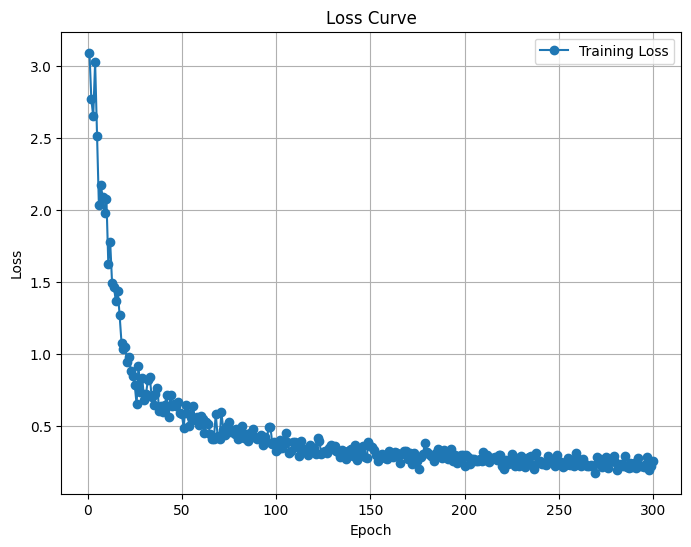

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_train)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_train) ** 2))
print(f"Training Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_train_cpu = y_train.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(predictions_cpu.numpy(), input_size, axis=1)))[:, 3]
y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(y_train_cpu.numpy(), input_size, axis=1)))[:, 3]
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_train_reversed) ** 2))
print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 1.0618
Training Loss Scaling Unreversed: 0.1640578657388687
Training Loss Scaling Reversed: 1186.2325439453125


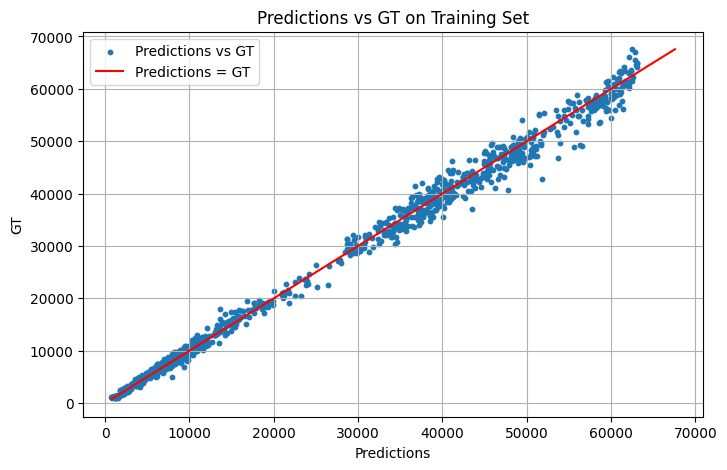

In [ ]:

# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.scatter(tensor1.numpy(), tensor2.numpy(), label='Predictions vs GT', marker='o', s=10)

min_val = min(tensor1.min(), tensor2.min())
max_val = max(tensor1.max(), tensor2.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='Predictions = GT')

plt.title('Predictions vs GT on Training Set')
plt.xlabel('Predictions')
plt.ylabel('GT')
plt.legend()
plt.grid(True)
plt.show()

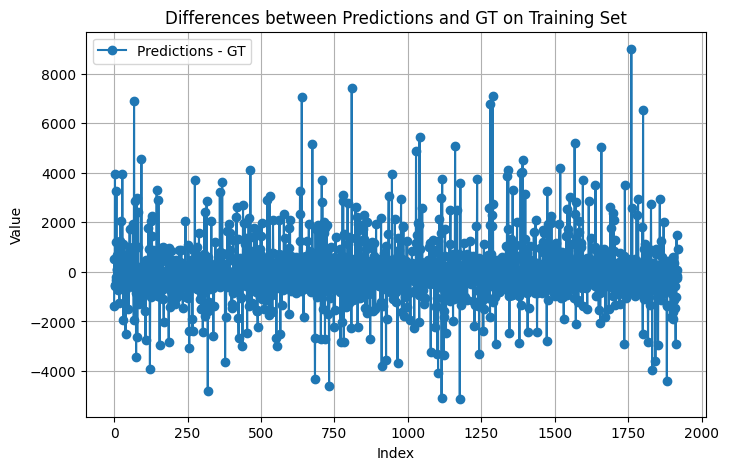

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_val) ** 2))
print(f"Validation Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_val_cpu = y_val.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(predictions_cpu.numpy(), input_size, axis=1)))[:, 3]
y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(y_val_cpu.numpy(), input_size, axis=1)))[:, 3]
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_val_reversed) ** 2))
print(f"Validation Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 2.8734
Validation Loss Scaling Unreversed: 0.18303881585597992
Validation Loss Scaling Reversed: 1323.475830078125


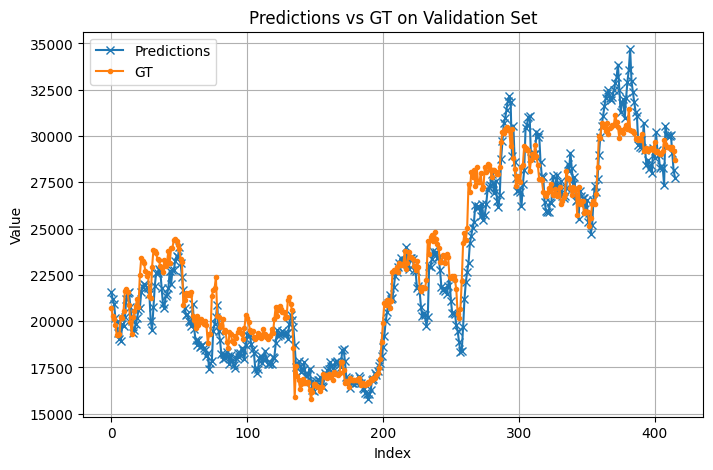

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.title('Predictions vs GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

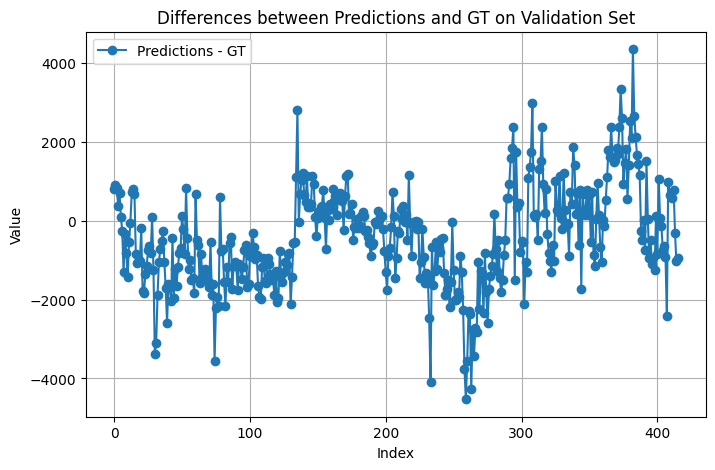

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Return

In [ ]:
def calculate_daily_long_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_long_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    signals[:-1] = torch.where(predicted_prices[1:] > predicted_prices[:-1], 1, 0)  # Buy if tomorrow's predicted price > today's
    return signals

  signals = generate_daily_trade_signals_long_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[1:] - true_prices[:-1]
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change
  # Calculate returns based on signals
  returns = signals[:-1] * percentage_returns

  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_long_trade_return_percentage(predicted_prices, true_prices)

Return: 0.1908341646194458
Max Drawdown: -0.31088533997535706


In [ ]:
def calculate_daily_short_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_short_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    # Generate a short signal (-1) if tomorrow's predicted price is lower than today's predicted price
    signals[:-1] = torch.where(predicted_prices[1:] < predicted_prices[:-1], 1, 0)
    return signals

  signals = generate_daily_trade_signals_short_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[:-1] - true_prices[1:]  # Since this is a short trade, we reverse the diff
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change
  # Calculate returns based on signals
  returns = signals[:-1] * percentage_returns
  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_short_trade_return_percentage(predicted_prices, true_prices)

Return: -0.24402809143066406
Max Drawdown: -0.36572691798210144
